In [2]:
import numpy as np
import pandas as pd
import SAGA
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

from SAGA import ObjectCuts as C

In [3]:
# Data manipulations

def get_radii(coordinates):
    radii = []
    for coordinate_pair in coordinates:
        radii.append(np.sqrt(coordinate_pair[0]**2+coordinate_pair[1]**2))
    return radii
    
def get_ellipticities(coordinates):
    # # First get quadrupole moments
    coordinates_squared = np.square(coordinates)

    xdiff_ydiff_col = np.prod(coordinates, axis=2)
    xdiff_ydiff_col = xdiff_ydiff_col[:,:,np.newaxis]

    quadrupole_moments_setup = np.insert(coordinates_squared, 0, [[[xdiff_ydiff_col]]], axis=2) # diffx*diffy now at position 0
    quadrupole_moments = quadrupole_moments_setup.mean(axis=1)

    # # Get ellipticity from quadrupole moments
    # Q_xy, Q_xx, Q_yy = np.quadrupole_moments
    quadrupole_xx_yy = quadrupole_moments[:,1:3]
    quadrupole_xy = quadrupole_moments[:,0:1]

    e_1_numerator = -np.diff(quadrupole_xx_yy, axis=1)
    e_2_numerator = 2*quadrupole_xy

    e_denominator_1 = np.sum(quadrupole_xx_yy, axis=1)[:,np.newaxis]
    e_denominator_inside_sqrt = np.prod(quadrupole_xx_yy, axis=1)[:,np.newaxis] - quadrupole_xy**2
    e_denominator = e_denominator_1 + 2*np.sqrt(e_denominator_inside_sqrt)

    e_1 = e_1_numerator / e_denominator
    e_2 = e_2_numerator / e_denominator

    ellipticities = np.sqrt(e_1**2 + e_2**2)[:,0]

    return ellipticities


def get_randomized_ellipticities(radii, num_repititions):
    num = len(radii)
    radial_stdev = np.std(radii)

    # Create "isotropic" (random from uniform - not uniform) angles
    coords = np.random.randn(num_repititions, num, 2)  # (number of times to repeat data set generation, how many satellites, how many spatial dimensions)
    calc_radii = np.sqrt((coords**2).sum(axis=2))
    normalized_coords = coords/calc_radii[:,:,np.newaxis]

    # Move the positions of satellites out or in radially until they reach original radial scale
    reshaped_radii = np.reshape(radii, (1,len(radii), 1))
    scaled_coords = normalized_coords*reshaped_radii

    ellipticities = get_ellipticities(scaled_coords,)
    
    return ellipticities


def get_prominence(actual, radii, num_repititions):
    randomized = get_randomized_ellipticities(radii, num_repititions)
    abv_actual = np.where(randomized > actual, 1, 0)
    p_above_actual = np.sum(abv_actual)/num_repititions
    prominence = 1/p_above_actual
    
    return prominence

In [4]:
# Dataframe manipulations
def filter_subhalo_dataframe_by_num_satellites(cutoff):
    filtered_dataframe = VSMDPL_subs_raw[VSMDPL_subs_raw['vmax_mpeak'] >= cutoff].copy()
    filtered_dataframe = filtered_dataframe.groupby(['HOSTID']).filter(lambda x: len(x) > 2).copy()
    return filtered_dataframe

def add_coordinate_columns(dataframe):
    dataframe['x_coord'] = dataframe['x_adj'] - dataframe['x_host']
    dataframe['y_coord'] = dataframe['y_adj'] - dataframe['y_host']
    # dataframe['z_coord'] = dataframe['z_adj'] - dataframe['z_host']
    # dataframe['3d_coordinates'] = dataframe[['x_coord', 'y_coord', 'z_coord']].values.tolist()
    dataframe['2d_coordinates'] = dataframe[['x_coord', 'y_coord']].values.tolist()

def get_systems_dataframe(dataframe):
    systems_df = dataframe.groupby('HOSTID')['2d_coordinates'].apply(tuple).reset_index(name='coordinates_list')
    systems_df['coordinates_list'] = systems_df['coordinates_list'].tolist()
    systems_df['radii'] = systems_df['coordinates_list'].apply(get_radii)
    return systems_df

def add_ellipticity_columns(dataframe):
    dataframe['ellipticity_actual'] = dataframe.apply(lambda x: get_ellipticities([x['coordinates_list']])[0], axis=1)
    dataframe['ellipticity_isotropic'] = dataframe.apply(lambda x: get_randomized_ellipticities(x['radii'], 1)[0], axis=1)

def add_num_subs_column(dataframe):
    dataframe['num_subs'] = dataframe['radii'].str.len()
    display(dataframe)

def add_prominence_columns(dataframe, num_iterations):
    dataframe['prominence'] = dataframe.apply(lambda x: get_prominence(x['ellipticity_actual'], x['radii'], num_iterations), axis=1)
    dataframe['prominence_isotropic'] = dataframe.apply(lambda x: get_prominence(x['ellipticity_isotropic'], x['radii'], num_iterations), axis=1)

def get_plot_data(dataframe):
    data_act = pd.DataFrame(dataframe['prominence'])
    data_act['Dataset'] = 'Actual'
    data_iso = pd.DataFrame(dataframe['prominence_isotropic']).rename(columns={"prominence_isotropic": "prominence"})
    data_iso['Dataset'] = 'Isotropic'
    plot_data = pd.concat([data_act,data_iso], ignore_index=True)
    return plot_data

def plot_that_bird_with_a_bat(that_bird, num_iterations):
    the_bat = {
        "figure.facecolor": "212946",
        "axes.facecolor": "212946",
        "savefig.facecolor": "212946", 
        "grid.color": "2A3459",
        "text.color": "0.9",
        "axes.labelcolor": "0.9",
        "xtick.color": "0.9",
        "ytick.color": "0.9",
        "grid.linestyle": "-",
        "lines.solid_capstyle": "round",
        "figure.figsize" : "(11.7,8.27)"
    }

    sns.set_style("darkgrid", the_bat)

    fig, ax1 = plt.subplots()
    sp1 = sns.ecdfplot(data=that_bird, x="prominence", hue="Dataset", hue_order=['Actual', 'Isotropic'], complementary=True, ax=ax1)
    ax1.set_xscale('log')
    ax1.set_xlim(1,num_iterations)

In [5]:
def get_ellipticity_and_prominence_data(dataframe, num_iterations):
    add_coordinate_columns(dataframe)
    systems_dataframe = get_systems_dataframe(dataframe).copy()
    add_ellipticity_columns(systems_dataframe)
    add_prominence_columns(systems_dataframe, num_iterations) # bottleneckyy
    plot_data = get_plot_data(systems_dataframe).copy()
    return [systems_dataframe, plot_data]

## Get Data

In [6]:
# from SAGA-halo-ellipticities (filtered + cartesian coords)
%store -r

iterations = 10000

# Apples to apples these bad boys
VSMDPL_subs_raw.rename(columns = {'upid':'HOSTID'}, inplace = True)
saga_sats.rename(columns = {'X':'x_adj', 'Y':'y_adj', 'HOST_X':'x_host', 'HOST_Y':'y_host'}, inplace = True)

# Use vmax_mpeak as proxy for luminosity
vmax_cutoff_for_avg_num = {
    '3.5' : 61,
      '4' : 51.6,
    '4.5' : 46.4,
      '5' : 43.5,
    '5.5' : 40.98,
    'saga': 44.09 # 4.855 sats per host on average
}

VSMDPL_subs_multi = {}
for cutoff in list(vmax_cutoff_for_avg_num.keys())[:5]:
    VSMDPL_subs_multi[cutoff] = filter_subhalo_dataframe_by_num_satellites(vmax_cutoff_for_avg_num[cutoff])
VSMDPL_subs = filter_subhalo_dataframe_by_num_satellites(vmax_cutoff_for_avg_num['saga'])
saga_sats = saga_sats.groupby(['HOSTID']).filter(lambda x: len(x) > 2).copy()

## SAGA Analysis

,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic
0,nsa126115,"([-0.0020247927082452113, 0.008711667929781064...","[0.008943877438233312, 0.0012570650928419062, ...",0.594528,0.947249,1.247505,133.333333
1,nsa127226,"([0.005553228030597074, 0.002269217403307905],...","[0.005998974010885905, 0.010283718519436004, 0...",0.536252,0.488464,10.905125,6.688963
2,nsa129237,"([-0.0020121298570342666, 0.002820599407806601...","[0.0034647435086724225, 0.0008636769851017844,...",0.286774,0.632487,1.083189,12.547051
3,nsa130133,"([-0.004797112631803922, -0.000940569312737060...","[0.004888451721585825, 0.008755640580899112, 0...",0.631965,0.472312,9.442871,3.796507
4,nsa133115,"([-0.0020419430153951145, -0.00457139672365330...","[0.005006715418630172, 0.0010109396589111578, ...",0.301248,0.008463,2.030045,1.000700
...,...,...,...,...,...,...,...
64,pgc67817,"([-0.0028500985388926516, 0.001457866082313908...","[0.003201317727961305, 0.006162889826653651, 0...",0.282646,0.305240,4.399472,5.428882
65,pgc68312,"([-0.0009163517156564263, 0.000918607745225452...","[0.0012975132586508186, 0.007369575481277809, ...",0.134362,0.303402,1.258336,3.090235
66,pgc69677,"([-0.002819107201387551, 0.003292271170450251]...","[0.004334329806635971, 0.0076545744461821675, ...",0.536936,0.348497,5.546312,2.097755
67,pgc72060,"([-0.003315844065320208, 0.0011990837164039814...","[0.00352599257294516, 0.005651237789069938, 0....",0.235636,0.162748,1.090988,1.003009


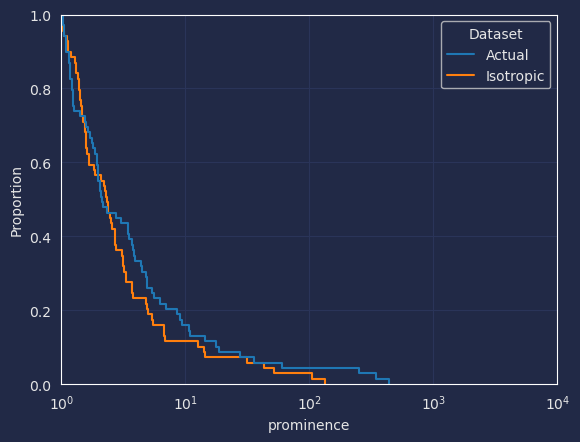

In [7]:
saga_data, saga_plot = get_ellipticity_and_prominence_data(saga_sats, iterations)
plot_that_bird_with_a_bat(saga_plot, iterations)
saga_data
# saga_data

#### Generate 100x isotropic data

## SIM Analysis

/tmp/ipykernel_11483/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual


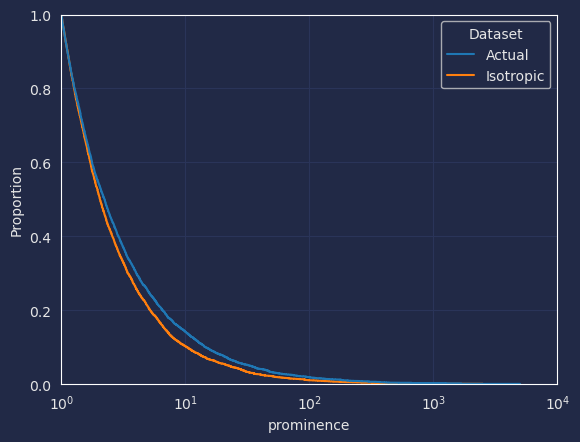

In [7]:
VSMDPL_data, VSMDPL_plot = get_ellipticity_and_prominence_data(VSMDPL_subs, iterations)
plot_that_bird_with_a_bat(VSMDPL_plot, iterations)
# VSMDPL_data


## SAGA + SIM

(1, 10000)

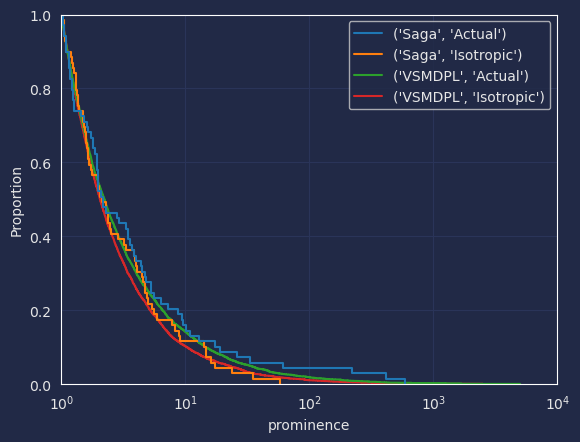

In [9]:
saga_plot['Datasource'] = 'Saga'
VSMDPL_plot['Datasource'] = 'VSMDPL'
saga_sim_data = pd.concat([saga_plot, VSMDPL_plot], ignore_index=True)

fig, ax1 = plt.subplots()
sp1 = sns.ecdfplot(data=saga_sim_data, x="prominence", hue=saga_sim_data[['Datasource', 'Dataset']].apply(tuple, axis=1), complementary=True, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlim(1,10000)

# generate more than 1 isotropic data points for saga so we can smooth orange data plot

In [ ]:

# ben as associate chair is in charge of all teaching in department
# for saga data, can plot ellipticity vs prominence can color by # sats
# can now plot other host properties vs prominence or ellipticity e.g. "disky" (Yao would generate)
# yao will send list of saga hosts w/ properties like orphology etc that we can plot against
# start writing thesis (can start w/ saga blurb on overleaf)
# educated guesses in discussion dection e.g. "see correlation" in result section "correlation may ..." in discussion section
# literature review - start reading now

,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource
0,nsa126115,"([-0.0020247927082452113, 0.008711667929781064...","[0.008943877438233312, 0.0012570650928419062, ...",0.594528,0.781982,1.253290,5.555556,Saga
1,nsa127226,"([0.005553228030597074, 0.002269217403307905],...","[0.005998974010885905, 0.010283718519436004, 0...",0.536252,0.118406,11.098779,1.171783,Saga
2,nsa129237,"([-0.0020121298570342666, 0.002820599407806601...","[0.0034647435086724225, 0.0008636769851017844,...",0.286774,0.534177,1.093733,4.555809,Saga
3,nsa130133,"([-0.004797112631803922, -0.000940569312737060...","[0.004888451721585825, 0.008755640580899112, 0...",0.631965,0.085760,10.090817,1.111852,Saga
4,nsa133115,"([-0.0020419430153951145, -0.00457139672365330...","[0.005006715418630172, 0.0010109396589111578, ...",0.301248,0.133632,1.956564,1.182033,Saga
...,...,...,...,...,...,...,...,...
5144,12570938344,"([0.1203460693359375, -0.07232666015625], [0.1...","[0.14040769983860557, 0.12561666938011307, 0.1...",0.034703,0.368044,1.014610,2.825657,VSMDPL
5145,12570938672,"([-0.0584564208984375, -0.02838134765625], [0....","[0.06498195164074566, 0.021604936622490474, 0....",0.387371,0.275159,10.341262,3.362475,VSMDPL
5146,12570938703,"([0.0452880859375, -0.0320587158203125], [0.07...","[0.05548668297826011, 0.08946230109388749, 0.0...",0.029346,0.117113,1.009489,1.179802,VSMDPL
5147,12570938803,"([0.0335845947265625, 0.032379150390625], [-0....","[0.0466511991589301, 0.12176103704525472, 0.11...",0.281119,0.792873,1.612383,29.761905,VSMDPL


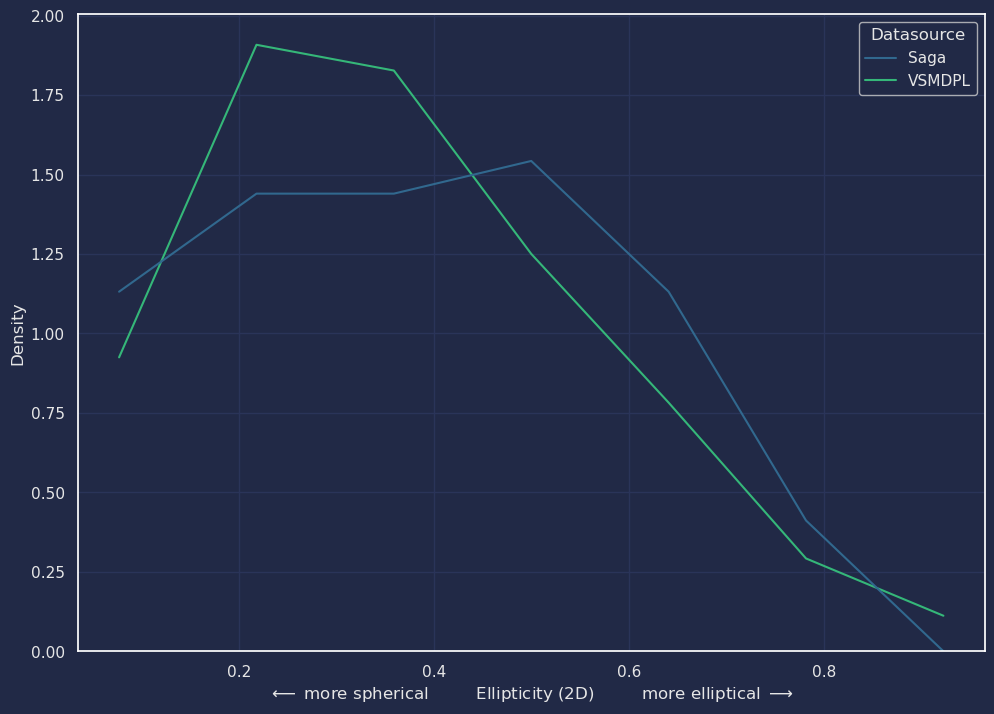

In [ ]:
saga_data['Datasource'] = 'Saga'
VSMDPL_data['Datasource'] = 'VSMDPL'
saga_sim_ellipticity_data = pd.concat([saga_data, VSMDPL_data], ignore_index=True)

fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(saga_sim_ellipticity_data, x="ellipticity_actual", hue="Datasource", hue_order=['Saga', 'VSMDPL'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')

## SIM Compare prominence for different avg # satellites

In [ ]:
VSMDPL_systems_multi = {}
VSMDPL_plot_multi = {}

for avg in list(vmax_cutoff_for_avg_num.keys())[:5]:
    VSMDPL_systems_multi[avg], VSMDPL_plot_multi[avg] = get_ellipticity_and_prominence_data(VSMDPL_subs_multi[avg], iterations)
    VSMDPL_plot_multi[avg]['Average # Satellites'] = avg
    VSMDPL_systems_multi[avg]['Datasource'] = 'VSMDPL ' + avg

/tmp/ipykernel_3618/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual
/tmp/ipykernel_3618/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual
/tmp/ipykernel_3618/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual
/tmp/ipykernel_3618/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual
/tmp/ipykernel_3618/3112009520.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  prominence = 1/p_above_actual


(1, 10000)

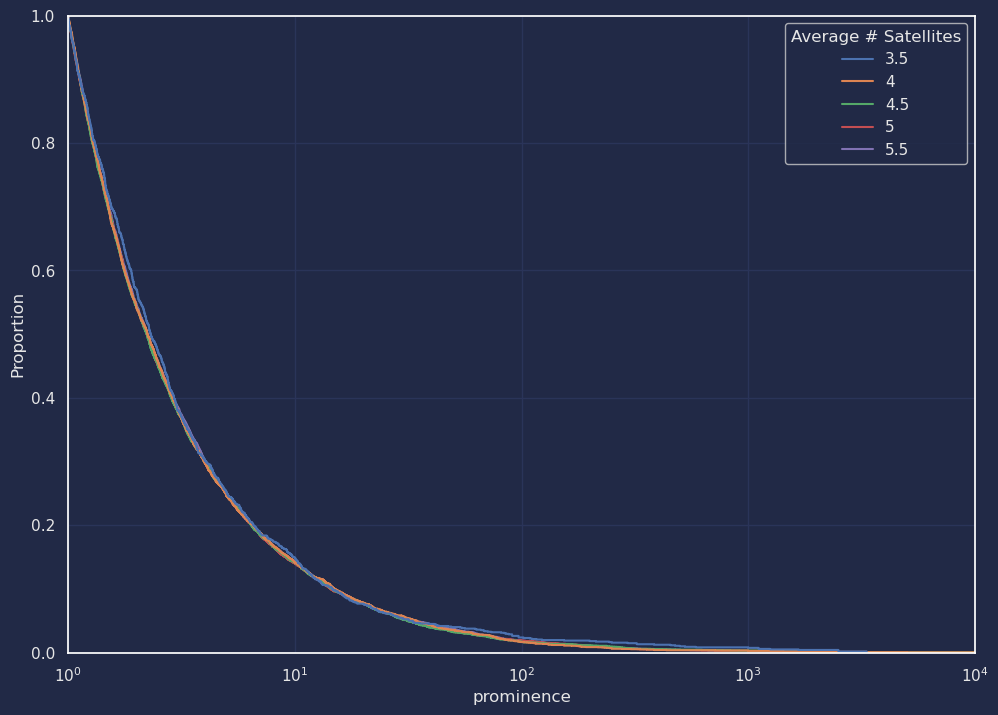

In [ ]:
VSMDPL_multi_plot_data = pd.concat(VSMDPL_plot_multi, ignore_index=True)
VSMDPL_multi_plot_data = VSMDPL_multi_plot_data[VSMDPL_multi_plot_data['Dataset'] == 'Actual'].copy()

fig, ax1 = plt.subplots()
sp1 = sns.ecdfplot(data=VSMDPL_multi_plot_data, x="prominence", hue='Average # Satellites', hue_order=['3.5', '4', '4.5', '5', '5.5'], complementary=True, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlim(1,iterations)

In [ ]:
for df in VSMDPL_systems_multi.values():
    add_num_subs_column(df)

,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource,num_subs
0,12507603697,"([0.013659954071044922, -0.005889892578125], [...","[0.014875657289844664, 0.03825096658849572, 0....",0.708028,0.766796,4.111842,7.710100,VSMDPL 3.5,3
1,12507603892,"([0.03396034240722656, 0.11245012283325195], [...","[0.11746631424212442, 0.12741699100296797, 0.1...",0.488691,0.605472,6.038647,12.345679,VSMDPL 3.5,4
2,12507605205,"([-0.08197021484375, -0.09918022155761719], [-...","[0.12866946984327154, 0.01695466809159071, 0.1...",0.255906,0.332275,1.955799,2.701243,VSMDPL 3.5,4
3,12507658991,"([-0.16453981399536133, -0.08047008514404297],...","[0.18316327413735983, 0.04552191703270074, 0.0...",0.372956,0.334410,2.311070,1.722060,VSMDPL 3.5,7
4,12507659299,"([-0.010089874267578125, 0.013849973678588867]...","[0.017135557581623648, 0.11054458521858213, 0....",0.226900,0.587251,1.263584,3.012956,VSMDPL 3.5,3
...,...,...,...,...,...,...,...,...,...
1219,12570854872,"([0.0196380615234375, -0.0219879150390625], [0...","[0.029480872920647164, 0.11965855795389646, 0....",0.535866,0.561353,3.138732,3.759398,VSMDPL 3.5,4
1220,12570893277,"([-0.0896453857421875, -0.0704803466796875], [...","[0.11403409337980695, 0.12039571352161867, 0.0...",0.509564,0.736535,4.777831,21.367521,VSMDPL 3.5,3
1221,12570910927,"([0.02435302734375, 0.1402130126953125], [-0.0...","[0.1423121880581607, 0.07254045813013409, 0.16...",0.558503,0.063073,13.513514,1.038422,VSMDPL 3.5,4
1222,12570938672,"([0.017547607421875, -0.012603759765625], [0.0...","[0.021604936622490474, 0.0305247679823904, 0.0...",0.444987,0.537034,1.007658,1.429593,VSMDPL 3.5,4


,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource,num_subs
0,12507603697,"([0.013659954071044922, -0.005889892578125], [...","[0.014875657289844664, 0.03825096658849572, 0....",0.635133,0.480207,7.352941,2.097755,VSMDPL 4,4
1,12507603892,"([-0.057979583740234375, -0.1273200511932373],...","[0.13990006278247133, 0.11746631424212442, 0.1...",0.474856,0.294699,14.880952,3.378378,VSMDPL 4,6
2,12507604502,"([-0.043799400329589844, 0.025890111923217773]...","[0.05087912503796049, 0.031677977379892426, 0....",0.357979,0.591757,1.182452,3.632401,VSMDPL 4,3
3,12507605205,"([-0.08197021484375, -0.09918022155761719], [0...","[0.12866946984327154, 0.18509231896875905, 0.0...",0.307147,0.365465,2.794857,4.448399,VSMDPL 4,6
4,12507658991,"([-0.16453981399536133, -0.08047008514404297],...","[0.18316327413735983, 0.04552191703270074, 0.0...",0.489675,0.361936,14.727541,3.194888,VSMDPL 4,9
...,...,...,...,...,...,...,...,...,...
3026,12570911041,"([-0.0311126708984375, 0.0695037841796875], [0...","[0.07614968355634223, 0.06677478493337102, 0.0...",0.370957,0.419744,2.001601,2.286760,VSMDPL 4,3
3027,12570937404,"([-0.0305633544921875, 0.0830841064453125], [-...","[0.08852732562113878, 0.13433060110091222, 0.0...",0.440535,0.670511,3.195909,12.626263,VSMDPL 4,3
3028,12570938672,"([-0.0584564208984375, -0.02838134765625], [0....","[0.06498195164074566, 0.021604936622490474, 0....",0.511133,0.494344,15.360983,12.738854,VSMDPL 4,7
3029,12570938703,"([0.0452880859375, -0.0320587158203125], [0.07...","[0.05548668297826011, 0.08946230109388749, 0.0...",0.029346,0.159163,1.009693,1.326964,VSMDPL 4,4


,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource,num_subs
0,12507603697,"([0.013659954071044922, -0.005889892578125], [...","[0.014875657289844664, 0.03825096658849572, 0....",0.082600,0.201545,1.100352,1.807664,VSMDPL 4.5,8
1,12507603892,"([-0.057979583740234375, -0.1273200511932373],...","[0.13990006278247133, 0.11746631424212442, 0.1...",0.473740,0.509035,18.518519,25.906736,VSMDPL 4.5,8
2,12507604502,"([-0.043799400329589844, 0.025890111923217773]...","[0.05087912503796049, 0.031677977379892426, 0....",0.325215,0.216439,1.823154,1.266945,VSMDPL 4.5,4
3,12507605205,"([-0.08197021484375, -0.09918022155761719], [0...","[0.12866946984327154, 0.12346203817350053, 0.1...",0.168597,0.224132,1.501502,2.079867,VSMDPL 4.5,7
4,12507658991,"([-0.16453981399536133, -0.08047008514404297],...","[0.18316327413735983, 0.04552191703270074, 0.0...",0.487824,0.284099,32.786885,2.780095,VSMDPL 4.5,10
...,...,...,...,...,...,...,...,...,...
4442,12570938344,"([0.1203460693359375, -0.07232666015625], [0.1...","[0.14040769983860557, 0.12561666938011307, 0.1...",0.034703,0.087416,1.013685,1.076079,VSMDPL 4.5,3
4443,12570938672,"([-0.0584564208984375, -0.02838134765625], [0....","[0.06498195164074566, 0.021604936622490474, 0....",0.387371,0.501156,9.970090,64.102564,VSMDPL 4.5,9
4444,12570938703,"([0.0452880859375, -0.0320587158203125], [0.07...","[0.05548668297826011, 0.08946230109388749, 0.0...",0.029346,0.096183,1.010203,1.122334,VSMDPL 4.5,4
4445,12570938803,"([0.0335845947265625, 0.032379150390625], [-0....","[0.0466511991589301, 0.12176103704525472, 0.11...",0.281119,0.403091,1.603592,2.187227,VSMDPL 4.5,3


,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource,num_subs
0,12507603697,"([0.013659954071044922, -0.005889892578125], [...","[0.014875657289844664, 0.03825096658849572, 0....",0.190446,0.083159,1.894657,1.137915,VSMDPL 5,9
1,12507603892,"([-0.057979583740234375, -0.1273200511932373],...","[0.13990006278247133, 0.11746631424212442, 0.1...",0.473740,0.286150,17.699115,3.429355,VSMDPL 5,8
2,12507604502,"([-0.043799400329589844, 0.025890111923217773]...","[0.05087912503796049, 0.031677977379892426, 0....",0.174101,0.096340,1.268070,1.051414,VSMDPL 5,6
3,12507605205,"([-0.08197021484375, -0.09918022155761719], [0...","[0.12866946984327154, 0.12346203817350053, 0.1...",0.168597,0.405301,1.508068,10.526316,VSMDPL 5,7
4,12507653347,"([-0.04372978210449219, 0.03155994415283203], ...","[0.0539288783291127, 0.027235261414024024, 0.0...",0.724998,0.473509,4.081633,1.736111,VSMDPL 5,3
...,...,...,...,...,...,...,...,...,...
5212,12570938672,"([-0.0584564208984375, -0.02838134765625], [0....","[0.06498195164074566, 0.021604936622490474, 0....",0.387371,0.111507,9.671180,1.224890,VSMDPL 5,9
5213,12570938703,"([0.0452880859375, -0.0320587158203125], [0.07...","[0.05548668297826011, 0.08946230109388749, 0.0...",0.029346,0.237532,1.010611,1.815211,VSMDPL 5,4
5214,12570938803,"([0.0335845947265625, 0.032379150390625], [-0....","[0.0466511991589301, 0.12176103704525472, 0.11...",0.281119,0.071237,1.605652,1.086957,VSMDPL 5,3
5215,12570938858,"([-0.110626220703125, 0.1301727294921875], [-0...","[0.1708306184807125, 0.14352384628463813, 0.07...",0.442301,0.154342,2.446782,1.208167,VSMDPL 5,3


,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic,Datasource,num_subs
0,12507603697,"([0.013659954071044922, -0.005889892578125], [...","[0.014875657289844664, 0.03825096658849572, 0....",0.206148,0.087649,2.460630,1.186380,VSMDPL 5.5,10
1,12507603892,"([-0.057979583740234375, -0.1273200511932373],...","[0.13990006278247133, 0.11746631424212442, 0.1...",0.141949,0.131853,1.384658,1.318218,VSMDPL 5.5,9
2,12507604502,"([-0.043799400329589844, 0.025890111923217773]...","[0.05087912503796049, 0.031677977379892426, 0....",0.174101,0.177473,1.268875,1.278609,VSMDPL 5.5,6
3,12507605205,"([-0.08197021484375, -0.09918022155761719], [-...","[0.12866946984327154, 0.08238506554075187, 0.1...",0.146290,0.163390,1.425517,1.554485,VSMDPL 5.5,8
4,12507653347,"([-0.04372978210449219, 0.03155994415283203], ...","[0.0539288783291127, 0.027235261414024024, 0.0...",0.724998,0.623666,3.965107,2.739726,VSMDPL 5.5,3
...,...,...,...,...,...,...,...,...,...
5815,12570938703,"([0.0452880859375, -0.0320587158203125], [0.07...","[0.05548668297826011, 0.08946230109388749, 0.0...",0.029346,0.267365,1.009489,2.105263,VSMDPL 5.5,4
5816,12570938803,"([-0.0861358642578125, 0.025390625], [-0.07699...","[0.08980017232350351, 0.07703750215502848, 0.0...",0.248397,0.345980,2.093802,3.937008,VSMDPL 5.5,5
5817,12570938858,"([-0.110626220703125, 0.1301727294921875], [-0...","[0.1708306184807125, 0.14352384628463813, 0.07...",0.442301,0.248790,2.518257,1.476669,VSMDPL 5.5,3
5818,12570938875,"([-0.0191192626953125, 0.0211181640625], [0.13...","[0.02848724380109516, 0.13441241666589385, 0.0...",0.665597,0.547707,13.422819,3.619254,VSMDPL 5.5,5


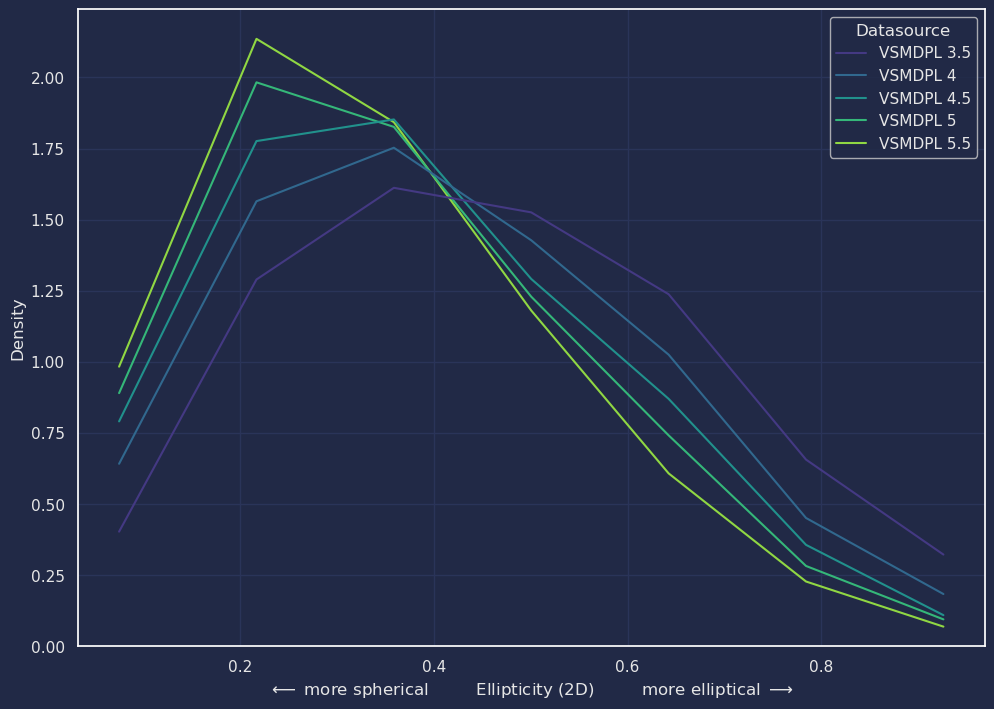

In [ ]:
VSMDPL_multi_data = pd.concat(VSMDPL_systems_multi, ignore_index=True)
fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(VSMDPL_multi_data, x="ellipticity_actual", hue="Datasource", hue_order=['VSMDPL 3.5', 'VSMDPL 4', 'VSMDPL 4.5', 'VSMDPL 5', 'VSMDPL 5.5'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')

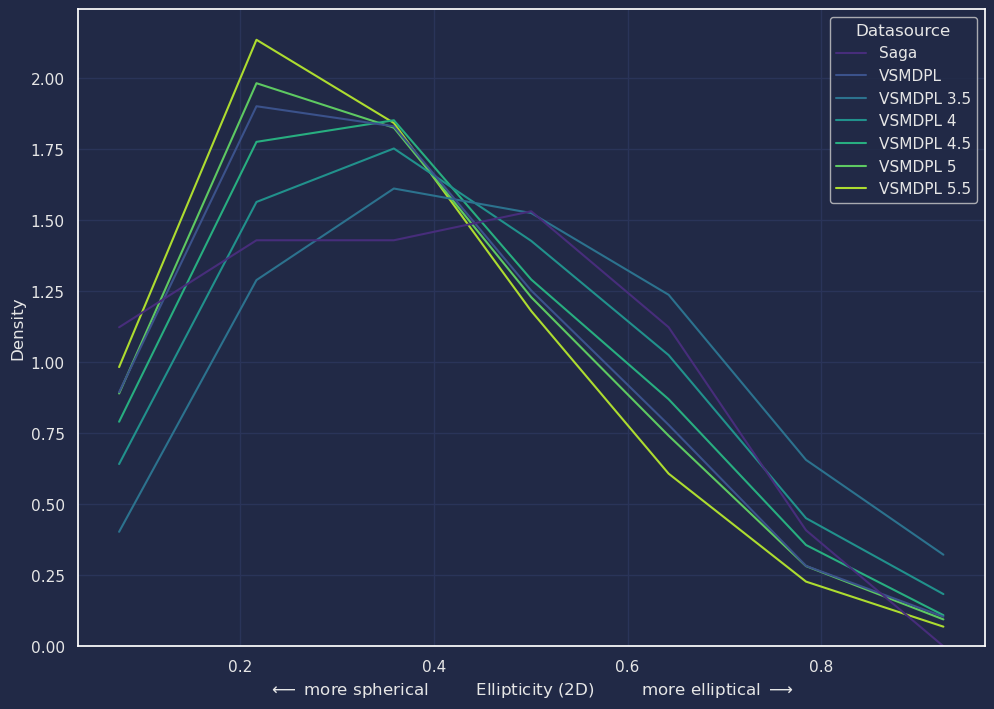

In [ ]:
all_data = pd.concat([VSMDPL_multi_data, saga_sim_ellipticity_data], ignore_index=True)

fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(all_data, x="ellipticity_actual", hue="Datasource", hue_order=['Saga', 'VSMDPL', 'VSMDPL 3.5', 'VSMDPL 4', 'VSMDPL 4.5', 'VSMDPL 5', 'VSMDPL 5.5'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')